In [499]:
import IPython.core.display
import matplotlib
import operator

def apply_styles():
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1
apply_styles()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import scale, PolynomialFeatures
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score

from sklearn.model_selection import train_test_split


# Data Exploration

In [500]:
#Load data
df = pd.read_csv("../Data/radar.csv", header=None,  names=['time','x','y','z'])#,index_col=0)
# df.head(5)
print("Shape:",df.shape)
print("Describe:")
df.describe()

Shape: (130, 4)
Describe:


,time,x,y,z
count,130.000000,130.000000,130.000000,130.000000
mean,645.000000,3461.523077,3238.405231,10737.692308
std,376.718286,1858.352781,1741.221296,4156.621418
min,0.000000,48.800000,8.480000,2590.000000
25%,322.500000,1912.500000,1820.000000,7267.500000
50%,645.000000,3555.000000,3340.000000,11250.000000
75%,967.500000,5115.000000,4732.500000,14300.000000
max,1290.000000,6370.000000,5970.000000,17000.000000


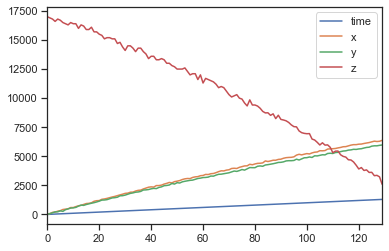

In [501]:
df.plot() #x grows faster than y, z has some random variances

In [502]:
df_buildings = pd.read_csv("../Data/mbuildings.csv")
df_buildings.head(5)
df_buildings.describe() #we can see there are missing residents

,residents,bed,bath,x,y
count,1656.000000,2417.000000,2417.000000,2417.000000,2417.000000
mean,2.175725,2.283409,2.103020,7158.813206,6650.869640
std,1.296489,1.200659,1.233391,69.128844,68.081989
min,0.000000,1.000000,1.000000,7024.160000,6514.160000
25%,1.000000,1.000000,1.000000,7101.760000,6597.360000
50%,2.000000,2.000000,2.000000,7157.280000,6650.000000
75%,3.000000,3.000000,3.000000,7215.360000,6705.360000
max,7.000000,9.000000,9.000000,7295.840000,6785.840000


Q1 (20). Using (any) methods you learned in this (wonderful) class estimate the expected point of impact. The
impact is obviously determined when altitude of the meteorite is 0.

## Ideas
- Predict phisics, aka. velocity, acceleration & direction.
    - Problem? What if there is wind or some other force we dont account for.
- Use different predictors that have biger memory for multiple hidden variables.

-get x & y variance, then predict the one with the least variance, use another model with the predicted variable as input too to predict the other coordinate

Polynomial regression

   

## Q1 - Predict x and y 

- Split train and test data.
- Base model (Linear Regression)
- Better model (Polynomial Regression)

In [503]:
#Split data
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
    return X_train, X_test, y_train, y_test

In [504]:
def plot_linear_reg(X_test, y_test, y_pred):
    plt.scatter(X_test, y_test,  color='gray')
    plt.plot(X_test, y_pred, color='red', linewidth=2)
    plt.show()
    #Todo: Show in the same figure the scatter plot and bar comparison
    # df_pred =  pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    # print(df_pred.head(25))
    # df_pred.plot(kind='bar',figsize=(10,6))
    # plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    # plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    # plt.show()

In [505]:
def linear_reg_model(X, y):
    X_train, X_test, y_train, y_test = split_data(X,y)

    regr = skl_lm.LinearRegression()
    regr.fit(X_train,y_train)    
    y_pred = regr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print("Regression Coefficient:",regr.coef_)
    print("Regression Intercept:",regr.intercept_)
    print("R^2: {}".format(regr.score(X_test, y_test)))
    print("Root Mean Squared Error: {}".format(rmse))

    plot_linear_reg(X_test, y_test, y_pred)
    return regr

Regression Coefficient: [-0.44152551]
Regression Intercept: 8197.319657838381
R^2: 0.9801654593380923
Root Mean Squared Error: 258.95083390621045


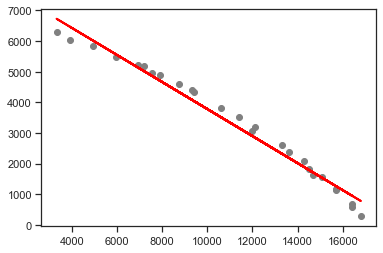

Regression Coefficient: [-0.41374108]
Regression Intercept: 7679.504324817695
R^2: 0.9792005584469581
Root Mean Squared Error: 247.84341884185372


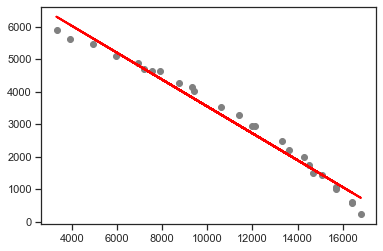

Regression Coefficient: [-0.09039464]
Regression Intercept: 1614.885625501803
R^2: 0.9925419778211156
Root Mean Squared Error: 31.923520314989943


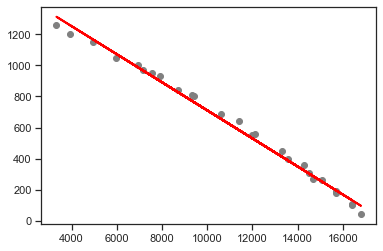

In [506]:
#Todo: Name plot and results. maybe add them all to a figure
model_reg_x = linear_reg_model(df[['z']].as_matrix(),df.x)
model_reg_y = linear_reg_model(df[['z']].as_matrix(),df.y)
model_reg_time = linear_reg_model(df[['z']].as_matrix(),df.time)

In [507]:
def predict_coord(model_reg_x, model_reg_y, model_reg_time, altitude=0):
    coord_x = model_reg_x.predict([[altitude]])
    coord_y = model_reg_y.predict([[altitude]])
    coord_time = model_reg_time.predict([[altitude]])
    print("Predicted points when altitude equals "+str(altitude)+" are: ", str(coord_time), str(coord_x),str(coord_y))
    # print("X: ")
predict_coord(model_reg_x, model_reg_y, model_reg_time)


Predicted points when altitude equals 0 are:  [1614.8856255] [8197.31965784] [7679.50432482]


### Polynomial approach

In [508]:
def calculate_degree():
    return 2
#Todo: Add code to check which degree of polynomial is best
#Added this later so i can use poly_reg_model when testing 1000 datasets
def poly(X,y):
    X_train, X_test, y_train, y_test = split_data(X,y)
    model=poly_reg_model(X_train, X_test, y_train, y_test)
    return model

def poly_reg_model(X_train, X_test, y_train, y_test):
    poly_degree = calculate_degree()
    polynomial_features= PolynomialFeatures(degree=poly_degree)
    x_poly = polynomial_features.fit_transform(X_train)

    model = skl_lm.LinearRegression()
    model.fit(x_poly, y_train)
    #######################################################
    ###########Train
    #######################################################
    # y_poly_pred = model.predict(x_poly)
    # rmse = np.sqrt(mean_squared_error(y_train,y_poly_pred))
    # r2 = r2_score(y_train,y_poly_pred)
    # print("Regression Coefficient:",model.coef_)
    # print("Regression Intercept:",model.intercept_)
    # print("R^2: {}".format(r2))
    # print("Root Mean Squared Error: {}".format(rmse))

    # plt.scatter(X_train, y_train, s=10)
    # # sort the values of x before line plot
    # sort_axis = operator.itemgetter(0)
    # sorted_zip = sorted(zip(X_train,y_poly_pred), key=sort_axis)
    # X_train_pol, y_poly_pred = zip(*sorted_zip)
    # plt.plot(X_train_pol, y_poly_pred, color='m')
    # plt.show()

    #######################################################
    #########Test
    #######################################################    
    x_test_poly = polynomial_features.fit_transform(X_test)
    y_poly_pred = model.predict(x_test_poly)

    rmse = np.sqrt(mean_squared_error(y_test,y_poly_pred))
    r2 = r2_score(y_test,y_poly_pred)
    print("Regression Coefficient:",model.coef_)
    print("Regression Intercept:",model.intercept_)
    print("R^2: {}".format(r2))
    print("Root Mean Squared Error: {}".format(rmse))

    plt.scatter(X_test, y_test, s=10)
    # sort the values of x before line plot
    #https://towardsdatascience.com/polynomial-regression-bbe8b9d97491
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(X_test,y_poly_pred), key=sort_axis)
    X_test_pol, y_poly_pred = zip(*sorted_zip)
    plt.plot(X_test_pol, y_poly_pred, color='m')
    plt.show()
    return model


In [509]:
# print( model.predict([[0,0,0]]))

Regression Coefficient: [ 0.00000000e+00 -7.74909110e-02 -1.78083483e-05]
Regression Intercept: 6646.244765531597
R^2: 0.9980989518461866
Root Mean Squared Error: 80.16832304227113


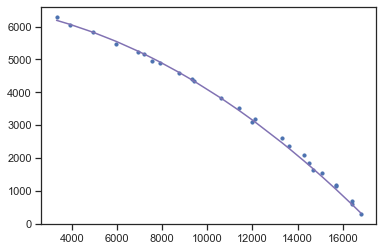

Regression Coefficient: [ 0.00000000e+00 -7.13435600e-02 -1.67498761e-05]
Regression Intercept: 6220.620447478522
R^2: 0.997454405626577
Root Mean Squared Error: 86.7054017962102


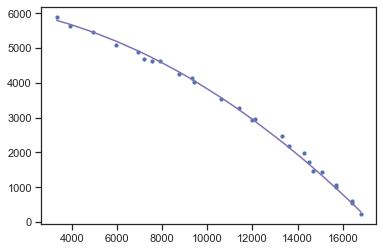

Regression Coefficient: [ 0.00000000e+00 -4.86204454e-02 -2.04356773e-06]
Regression Intercept: 1436.8945765697163
R^2: 0.998422261523135
Root Mean Squared Error: 14.683055813826943


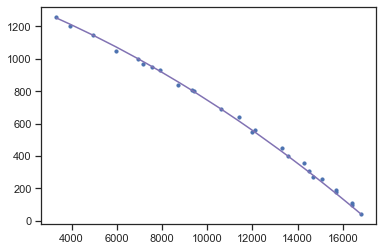

In [497]:
model_reg_x = poly(df[['z']].as_matrix(),df.x)
model_reg_y = poly(df[['z']].as_matrix(),df.y)
model_reg_time = poly(df[['z']].as_matrix(),df.time)

In [498]:
def predict_coord(model_reg_x, model_reg_y, model_reg_time, altitude=0):
    coord_x = model_reg_x.predict([[altitude,altitude,altitude]]) # 3 times because model was trainded with polynomials of degree 2
    coord_y = model_reg_y.predict([[altitude,altitude,altitude]])
    coord_time = model_reg_time.predict([[altitude,altitude,altitude]])
    print("Predicted points when altitude equals "+str(altitude)+" are: ", str(coord_time), str(coord_x),str(coord_y))
    # print("X: ")
predict_coord(model_reg_x, model_reg_y, model_reg_time)


Predicted points when altitude equals 0 are:  [1436.89457657] [6646.24476553] [6220.62044748]


## Q2 - Resampling

“You create multiple (at least 1000, feel free to go for more) new datasets based on resampling (with
replacement) from the original dataset (note that the original dataset has 130 data points). For each one of these
1000 new datasets, you pick 130 data points (from the 130 original ones) using the following process: You pick
one data point randomly, then you “put it back” (that is the meaning of resampling with replacement) and you
repeat the same process 129 times.

In [492]:
# amount_datasets = 1000
# df_1000 = []
# for i in range(amount_datasets):
#     df_resample = df.sample(n=130,replace=True)
#     df_1000.append(df_resample)

In [493]:
#Split data
#MAnually:
###Create a list with numbers from 0 to n (range function?), sample n numbers with replacement, this will be the indexes for train data.
###Get the missing numbers from the previous list, this will be the test data. (? How do we control the amount of test data, what if they are jsut 10)

# ##Approach 2: split randomly data between train and test 
# def split_data_with_resampling(X, y):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
#     df_resample = df.sample(n=130,replace=True)
#     df_1000.append(df_resample)
#     return X_train, X_test, y_train, y_test


In [494]:
#If i want to set a max of test points then i could first sample the test points with a limit of 30 for example and no repetitions, then for test the reamining oversample to 130
def split_data_with_resampling(X, y, seed=42, n=130):
    np.random.seed(seed)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)    
    zero_to_n = np.arange(n) #ndarray with numbers from 0 to n (130)
    train_indices = np.random.randint(0, n, size=n) # ndarray with n random numbers from 0 to n with repetions.
    test_indices = np.setdiff1d(zero_to_n,train_indices) # the indices not in train_indeces go to test indices, size vary. 
    # size_test_indices = len(np.unique(test_indices))
    # print(size_test_indices)
    # print(zero_to_n)
    # print(train_indices)
    X_train = X[train_indices]
    X_test  = X[test_indices]
    y_train = y[train_indices]
    y_test  = y[test_indices]
    return X_train, X_test, y_train, y_test

def create_datasets_resampling(x, y, amount_datasets = 1000):
    df_1000 = []
    for seed in range(amount_datasets):
        df_resample = split_data_with_resampling(x,y, seed)
        df_1000.append(df_resample)
    return df_1000

def test_confidence():
    datasets_x = create_datasets_resampling(df[['z']].as_matrix(),df.x)
    models = [poly_reg_model(*splitted_data) for splitted_data in datasets_x] 
    predictions = [model.predict([[0,0,0]]) for model in models]
    print(np.mean(predictions))
    
# model_reg_x = poly_reg_model(df[['z']].as_matrix(),df.x)
# model_reg_y = poly_reg_model(df[['z']].as_matrix(),df.y)
# model_reg_time = poly_reg_model(df[['z']].as_matrix(),df.time)

In [495]:
test_confidence()

TypeError: poly_reg_model() takes 2 positional arguments but 4 were given